In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import datetime as dt

# opencv
import cv2

# tensorflow/keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Lambda, Concatenate,Flatten, concatenate, LSTM, MaxPooling2D, Permute, Reshape, TimeDistributed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

Get lists of file names and labels

In [3]:
print('Training images :', len(os.listdir('/kaggle/input/skyfield-train-kolkata-andaman/0'))) # should now have 90% of the files

# training
files_train = os.listdir('/kaggle/input/skyfield-train-kolkata-andaman/0')
files_train = [f for f in files_train if f.endswith('.png')]

# sort
files = sorted(files_train)

Training images : 15506


---

Function to Extract Position and Time from Image File Title

In [7]:
# extract position and time from filename

def extract_position_time(filepath):
    """
    The labels corresponding to the image are encoded in the title. This function
    parses the labels.

    args
    ---
    filepath(str): ex: cloud_cover0/L38.0241LON-138.9065T2020-03-13-04-00-00.png
    
    The string is parsed to extract the latitude, longitude and time of the image.
    """
    # filename = filepath.split("/")[-1]
    filename = filepath
    # extract position
    lat = re.search('L(.*?)LON', filename).group(1)
    long = re.search('LON(.*?)T', filename).group(1)
    # extract time
    time = re.search('T(.*?)\.png', filename).group(1)
    # convert time to np.datetime64
    time = dt.datetime.strptime(time, '%Y-%m-%d-%H-%M-%S')
    time = np.datetime64(time)
    # return position and time
    return (float(lat), float(long)), time


# Functions to normalize training data

In [8]:

def normalize_times(times_array, master_times):
 
    times = np.array(times_array)
    times = (times - master_times.min()) / (master_times.max() - master_times.min())
    return times

def normalize_datetime(time, min_time, max_time):
    
    # normalize the datetime64 object
    normalized_time = (time - min_time) / (max_time - min_time)
    return normalized_time

def normalize_y(pos_array, master_pos):
    lat_min, lat_range, long_min, long_range = get_lat_long_bounds(master_pos)
    
    y_norm = np.zeros(pos_array.shape)
    
    y_norm[:,0] = (pos_array[:,0] - lat_min) / lat_range
    y_norm[:,1] = (pos_array[:,1] - long_min) / long_range

    return y_norm

def get_lat_long_bounds(y):
    lat_min = y[:,0].min()
    lat_max = y[:,0].max()
    long_min = y[:,1].min()
    long_max = y[:,1].max()
    lat_range = lat_max - lat_min
    long_range = long_max - long_min
    return lat_min, lat_range, long_min, long_range
  

# Prepare Training Data

In [10]:
# create array of position
position = np.array([extract_position_time(f)[0] for f in files])

# create array of time
times = np.array([extract_position_time(f)[1] for f in files])

# normalize positions
y_norm = normalize_y(position, position)

# normalize times
norm_times = normalize_times(times, times)
#############

## Loss Functions

In [11]:
def haversine_loss(y_true, y_pred, R=3443.92):
    # shamelessly borrowed from this very similar project: https://github.com/gregtozzi/deep_learning_celnav
    
    # Convert normalized lat and long into actuals
    lat_min, lat_range, long_min, long_range = get_lat_long_bounds(position)
    lat1  = y_true[:,0] * lat_range + lat_min
    lat2  = y_pred[:,0] * lat_range + lat_min
    long1 = y_true[:,1] * long_range + long_min
    long2 = y_pred[:,1] * long_range + long_min 
    
    # Compute phis and lambdas 
    phi1 = lat1 * np.pi / 180
    phi2 = lat2 * np.pi / 180
    delta_phi    = (lat2 - lat1) * np.pi / 180
    delta_lambda = (long2 - long1) * np.pi / 180
    
    # Intermediate computations
    a = tf.square(tf.sin(delta_phi / 2)) + tf.cos(phi1) * tf.cos(phi2) * tf.square(tf.sin(delta_lambda / 2))
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    
    # Compute distances
    d = R * c
    
    # Compute the mean squared distance (MSE)
    return tf.reduce_mean(d)

# Early Stopping

In [12]:

# define the early stopping callback
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=10)


# EXPERIMENTAL MODEL

In [ ]:

# define the input layers
samples_size = 41 
input_image = Input(shape=(samples_size, 224,224,1))
input_time = Input(shape=(samples_size, 1))

# process the input image using a CNN
x = TimeDistributed(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))(input_image)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))(x)
x = TimeDistributed(MaxPooling2D())(x)
x = TimeDistributed(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))(x)
x = TimeDistributed(Flatten())(x)

# flatten the input time
t = TimeDistributed(Flatten())(input_time)

# concatenate the CNN and LSTM outputs
z = concatenate([x, t])

# pass to LSTM
z = LSTM(64, activation='relu', return_sequences=True)(z)

# z = concatenate([x, t])
z = Dense(64, activation='relu')(z)
z = Dropout(0.2)(z)
outputs = Dense(2, activation='sigmoid')(z)
print(outputs)

# define the model
experimental_model = Model(inputs=[input_image, input_time], outputs=outputs)
experimental_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 2), dtype=tf.float32, name=None), name='dense_10/Sigmoid:0', description="created by layer 'dense_10'")

Model: "model_3"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_7 (InputLayer)           [(None, 41, 224, 22  0           []                               

                                4, 1)]                                                            

                                                                                                  

 time_distributed (TimeDistribu  (None, 41, 224, 224  160        ['input_7[0][0]']                

 ted)                           , 16)                                                             

                                                                                                  

 time_distributed_1 (TimeD

# MonteCarlo Drop Out Layers

- Based on this idea: https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571#:~:text=Monte%20Carlo%20Dropout%20boils%20down,softmax%20outputs%20for%20each%20class.

In [13]:
# from tensorflow.keras.layers import Layer
class MCdropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

input_image = Input(shape=(224,224,1))
input_time = Input(shape=times[0].shape)

x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(input_image)
x = MaxPooling2D()(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Flatten()(x)

# flatten the input time
t = Flatten()(input_time)

# Pass the time input through 3 dense layers
t = Dense(128, activation='relu')(t)
t = Dense(64, activation='relu')(t)
t = Dense(32, activation='relu')(t)

# concatenate the output of the CNN and Dense layers 
z = concatenate([x, t])
z = Dense(256, activation='relu')(z)
z = MCdropout(0.2)(z) # MC Dropout layer
z = Dense(256, activation='relu')(z)
z = MCdropout(0.2)(z) # MC Dropout layer
outputs = Dense(2, activation='sigmoid')(z)

mc_model = Model(inputs=[input_image, input_time], outputs=outputs)
mc_model.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               

                                )]                                                                

                                                                                                  

 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                

                                )                                                                 

                                                                                                  

 max_pooling2d (MaxPooling2D)   (None, 112, 112, 16  0           ['conv2d[0][0]']                 

                                )                                                  

# Custom Transformer Code

Current Custom Generator

In [14]:
class CustomGenerator(Sequence):
    def __init__(self, directory, batch_size=32, segment = 'Train'):
        
        self.directory = directory
        self.batch_size = batch_size
        self.segment = segment

    def __len__(self):
        if self.segment !='Train':
            return int(np.floor(len(files_val) / self.batch_size))
        else:
            return int(np.floor(len(files_train) / self.batch_size))

    def __getitem__(self, idx):

        # get batch of images
        batch = os.listdir(self.directory)[idx * self.batch_size:(idx + 1) * self.batch_size]
        # create empty array to hold images
        # batch.sort()
        x = np.empty((self.batch_size, 224, 224, 1))
        y = np.zeros((self.batch_size, 2))
        times_gen = []
        # loop through batch
        for i, img in enumerate(batch):
            # populate time and position labels 
            y[i] = extract_position_time(img)[0]
            time = extract_position_time(img)[1]
            times_gen.append(normalize_datetime(time, times.min(), times.max()))
             # read image
            img = cv2.imread(os.path.join(self.directory, img),0)
            img = cv2.resize(img, (224, 224))
            # add image to x
            x[i] = img.reshape(224, 224, 1)
        # get output
        output = normalize_y(y, position)
        # get time input
        time_input = np.array(times_gen) 
        
        return [x/255, time_input], output

custom_gen_train = CustomGenerator(directory = '/kaggle/input/skyfield-train-kolkata-andaman/0', segment = 'Train')
custom_gen_val = CustomGenerator(directory = '/kaggle/input/skyfield-kolkata-andaman-val/0_val', segment = 'Validate')

In [15]:
with tf.device(device_name):
  # Compile and train the model
    mc_model.compile(optimizer='adam', loss=haversine_loss, metrics=haversine_loss)
    history_mc = mc_model.fit(custom_gen_train, batch_size = 32, epochs = 100, shuffle = False, callbacks = [early_stopping])

mc_model.save('../content/drive/MyDrive/mc_model.h5')

Epoch 1/100

2458/2458 [==============================] - 425s 169ms/step - loss: 4.4668 - haversine_loss: 4.4668

Epoch 2/100

2458/2458 [==============================] - 414s 168ms/step - loss: 2.7526 - haversine_loss: 2.7526

Epoch 3/100

2458/2458 [==============================] - 415s 169ms/step - loss: 2.4993 - haversine_loss: 2.4993

Epoch 4/100

2458/2458 [==============================] - 412s 168ms/step - loss: 2.3133 - haversine_loss: 2.3133

Epoch 5/100

2458/2458 [==============================] - 412s 168ms/step - loss: 2.2219 - haversine_loss: 2.2219

Epoch 6/100

2458/2458 [==============================] - 413s 168ms/step - loss: 2.1291 - haversine_loss: 2.1291

Epoch 7/100

2458/2458 [==============================] - 413s 168ms/step - loss: 2.0739 - haversine_loss: 2.0739

Epoch 8/100

2458/2458 [==============================] - 412s 168ms/step - loss: 2.0189 - haversine_loss: 2.0189

Epoch 9/100

2458/2458 [==============================] - 411s 167ms/step - loss

Text(0, 0.5, 'Haversine Loss in NM')

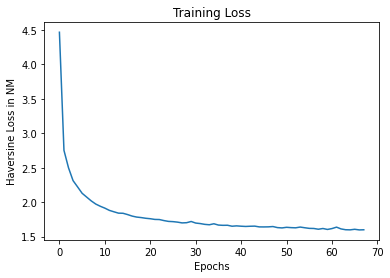

In [16]:
plt.plot(history_mc.history['haversine_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Haversine Loss in NM')

In [17]:
mc_model.save('mc_model.h5')